In [ ]:
import os
from typing import Dict, NamedTuple, Union, List, Tuple
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
class Config(NamedTuple):
    data: str = "../pre_vertical.csv"
    dirctory: str = "../images/mla"
    savefile: bool = False
    kwarg_savefig: Dict[str, Union[str, int, float]] = {
        "facecolor": "white",
        "dpi": 300,
        "bbox_inches": "tight",
        "pad_inches": 0.05
    }

In [3]:
conf = Config(savefile=True)

In [4]:
os.makedirs(conf.dirctory, exist_ok=True)

In [5]:
# load result data

res = pd.read_csv(conf.data, index_col=0)

In [6]:
res.head(2)

,time,size
0,4.94,1.0
1,5.68,1.5


In [7]:
def power(
    data: pd.core.frame.DataFrame, 
    dim: int,
    subtract_scale: bool = True,
    name_digit: int = 3
    ) -> pd.core.frame.DataFrame:

    assert isinstance(dim, int) and dim >= 1, \
        f"dim expected non-zero positive int; got {dim}"
    assert isinstance(name_digit, int) and name_digit >= 0, \
        f"name_digit expected positive int; got {name_digit}"

    ret = pd.DataFrame(index=data.index)

    for i in range(dim):
        temp = data ** (i + 1) if not subtract_scale \
            else (data - data.mean()) ** (i + 1)
        if subtract_scale:
            temp.columns = [
                f"({name}-{data.mean()[j].round(name_digit)})" + \
                    f"*({name}-{data.mean()[j].round(name_digit)})" * (i) for j, name in enumerate(temp.columns)
                ]
        else:
            temp.columns = [
                f"{name}" + f"*{name}" * (i) for name in temp.columns
                ]
        ret = pd.concat([ret, temp], axis=1)
    
    return ret

def feat_selector(data: pd.core.frame.DataFrame) -> List[pd.core.frame.DataFrame]:
    ret = []
    for i in range(len(data)):
        l_comb = list(combinations(data.columns, i + 1))
        ret += [data.loc[:, list(comb)] for comb in l_comb]
    return ret


In [8]:
res.head(2)

,time,size
0,4.94,1.0
1,5.68,1.5


In [10]:
power(res.iloc[:, 1:], 3, True, 2).head(2)

,(size-1.99),(size-1.99)*(size-1.99),(size-1.99)*(size-1.99)*(size-1.99)
0,-0.994,0.988036,-0.982108
1,-0.494,0.244036,-0.120554


In [10]:
power(res.iloc[:, 1:], 1, True, 2).head(2)

,(pod-8.0),(body-2.0),(wing-10.0),(width-6.0),(thickness-3.0),(fixation-0.0),(thread-0.0),(shape-0.0)
1,4.0,0.5,-5.0,2.0,-2.0,-1.0,-1.0,-1.0
2,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,1.0


In [11]:
x_df = pd.concat(
    [
        power(res.iloc[:, 1:], 1, True, 2),
        power(res.iloc[:, 1:], 3, True, 2),
    ],
    axis=1
)

x_df = x_df.loc[:, ~x_df.columns.duplicated()]

In [12]:
x_df.head()

,(size-1.99),(size-1.99)*(size-1.99),(size-1.99)*(size-1.99)*(size-1.99)
0,-0.994,0.988036,-9.821078e-01
1,-0.494,0.244036,-1.205538e-01
2,0.006,0.000036,2.160000e-07
3,0.506,0.256036,1.295542e-01
4,0.976,0.952576,9.297142e-01


In [13]:
df_sep = feat_selector(x_df)

In [14]:
y_df = res.time

In [15]:
l_x = [sm.add_constant(x) for x in df_sep]

l_model = [sm.OLS(y_df, x) for x in l_x]
l_result = [model.fit() for model in l_model]
l_aic = [result.aic for result in l_result]

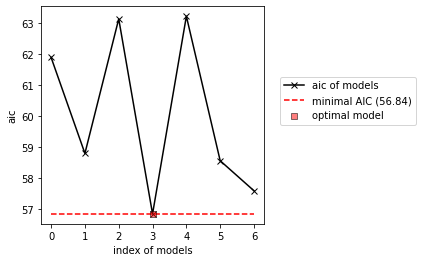

In [18]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(
    np.arange(len(l_aic)),
    l_aic, label="aic of models", c="k", marker="x"
)
ax.plot(
    np.arange(len(l_aic)),
    np.array(l_aic).min() * np.ones(len(l_aic)), linestyle="--",
    c="r", label=f"minimal AIC ({np.array(l_aic).min().round(2)})"
)

ax.scatter(
    l_aic.index(min(l_aic)), min(l_aic),
    c="r", marker="s", edgecolor="k", zorder=3, alpha=0.5,
    label="optimal model"
)

ax.set(ylabel="aic", xlabel="index of models")

ax.legend(bbox_to_anchor=(1.05, 0.7));

if conf.savefile:
    plt.savefig(f"{conf.dirctory}/aic.png", **conf.kwarg_savefig)

In [19]:
summary = l_result[l_aic.index(min(l_aic))].summary()

summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.279
Method:                 Least Squares   F-statistic:                     5.635
Date:                Mon, 18 Oct 2021   Prob (F-statistic):             0.0106
Time:                        18:15:56   Log-Likelihood:                -25.421
No. Observations:                  25   AIC:                             56.84
Df Residuals:                      22   BIC:                             60.50
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                       6.2709      0.224     28.040      0.000       5.807       6.735
(size-1.99)                 0.3965      0.204      1.942      0.065      -0.027       0.820
(size-1.99)*(size-1.99)    -0.9450      0.353     -2.678      0.014      -1.677      -0.213
==============================================================================
Omnibus:                        5.001   Durbin-Watson:                   1.759
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                3.442
Skew:                           0.478   Prob(JB):                        0.179
Kurtosis:                       4.546   Cond. No.                         3.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
if conf.savefile:
    with open(f"{conf.dirctory}/README.md", "w") as f:
        f.write(
            f"""
            feature set:
            {x_df.columns}
            
            optimal model:
            {summary}
            
            """
        )